# Grain Boundary Energy Frequency Distribution Analysis for Anisotropic Polycrystalline Systems

## Research Objectives
This notebook performs comprehensive grain boundary (GB) energy frequency distribution analysis on large-scale polycrystalline microstructures with anisotropic energy functions. The analysis focuses on characterizing the distribution of normalized grain boundary energies and their relationship to grain morphology, specifically distinguishing between major, minor, and matrix grain boundaries in elongated grains.

## Scientific Framework
### Energy Function Formulations
- **Cosine Function**: γ(θ) = 1 + σ*cos(2θ), modeling smooth anisotropic energy variation
- **CosMin1 Function**: γ(θ) = (1 + σ*cos(2θ))/(1-σ), normalized cosine energy function
- **Well Function**: Discrete energy wells at specific inclination angles (90° and 135°)
- **CosMax1Mobility**: Constant mobility function for reference comparison

### Microstructural Analysis Framework
1. **Grain Classification**: Systematic identification of grain morphology using aspect ratio analysis
2. **Boundary Categorization**: Classification of grain boundaries into major, minor, and matrix types
3. **Energy Distribution**: Statistical analysis of normalized energy frequencies γ_GB/γ_ave
4. **Morphological Correlation**: Relationship between grain shape and boundary energy distribution

## Methodology Overview
### Data Processing Pipeline
1. Load SPPARKS Monte Carlo simulation results from HiPerGator cluster
2. Extract microstructure snapshots at target grain count (1000 grains)
3. Calculate grain boundary normal vectors using linear programming methods
4. Determine anisotropic energy values based on inclination angles
5. Perform grain morphology analysis with elliptical fitting
6. Classify boundaries by orientation relative to grain major/minor axes
7. Generate frequency distributions for different boundary types

### Statistical Analysis
- **Normalization**: Energy values normalized by average grain boundary energy
- **Binning**: Energy frequencies binned over range [0, 8.0] with bin width 0.12501
- **Categorization**: Boundaries classified as major (perpendicular to long axis), minor (parallel to long axis), or matrix (intermediate orientations)
- **Visualization**: Stacked bar charts showing frequency contributions from each boundary type

## Key Parameters
- **Initial Grain Count**: 20,000 grains (large-scale statistical significance)
- **Target Analysis Count**: 1,000 grains (post-coarsening analysis point)
- **Anisotropy Parameter**: σ = 0.8 (strong anisotropic energy variation)
- **Aspect Ratio Threshold**: c0 = 0.67 (threshold for elongated grain classification)
- **Angular Tolerance**: ±10° (classification tolerance for major/minor boundaries)
- **Minimum Grain Size**: 500 sites (excludes small grains from boundary analysis)

## Output Products
1. **Overall Energy Distribution**: Complete frequency distribution for all grain boundaries
2. **Categorized Distributions**: Separate frequency analysis for major, minor, and matrix boundaries
3. **Morphological Statistics**: Average aspect ratios and grain shape characterization
4. **Publication-Quality Figures**: High-resolution plots for scientific documentation

## Technical Implementation
- **VECTOR Framework**: Advanced grain boundary analysis with normal vector computation
- **SPPARKS Integration**: Monte Carlo grain growth simulation data processing
- **OpenCV Analysis**: Elliptical fitting for grain morphology characterization
- **HiPerGator Data**: University of Florida supercomputing cluster simulation results

In [ ]:
# =============================================================================
# LIBRARY IMPORTS AND ENVIRONMENT SETUP
# =============================================================================
# This section imports all necessary libraries for grain boundary energy 
# frequency analysis in anisotropic polycrystalline systems

# Core scientific computing libraries
import os  # Operating system interface for file path management
current_path = os.getcwd()  # Get current working directory for relative paths

import numpy as np  # Numerical computing foundation for array operations
from numpy import seterr  # NumPy error handling configuration
seterr(all='raise')  # Set NumPy to raise exceptions for numerical errors (overflow, underflow, invalid operations)

import matplotlib.pyplot as plt  # Advanced plotting and visualization library
import math  # Mathematical functions for trigonometric operations and constants
from tqdm import tqdm  # Progress bar library for long-running computations

# System path management for custom module imports
import sys
sys.path.append(current_path)  # Add current directory to Python path
sys.path.append(current_path+'/../../')  # Add VECTOR root directory to path

# VECTOR Framework custom modules
import myInput  # Custom input/output utilities and gradient computation functions
import PACKAGE_MP_Linear as linear2d  # 2D linear programming for grain boundary normal vector computation
import post_processing as inclination_processing  # Post-processing utilities for inclination angle analysis

# Computer vision library for morphological analysis
import cv2  # OpenCV library for elliptical fitting and geometric shape analysis

# Additional custom module path for tangent calculation utilities
sys.path.append(current_path+'/../calculate_tangent/')  # Access to specialized geometric computation modules

In [ ]:
# =============================================================================
# UTILITY FUNCTIONS FOR GRAIN BOUNDARY ENERGY FREQUENCY ANALYSIS
# =============================================================================
# This section contains specialized functions for statistical analysis of grain
# boundary energy distributions, morphological characterization, and geometric
# computations in anisotropic polycrystalline systems

def simple_magnitude(freqArray):
    """
    Calculate texture magnitude metrics for frequency distribution analysis.
    
    This function computes statistical measures of deviation from uniform circular
    distribution, providing quantitative metrics for texture strength in grain
    boundary inclination distributions.
    
    Parameters:
    -----------
    freqArray : numpy.ndarray
        Frequency distribution array representing inclination angle histogram
        
    Returns:
    --------
    magnitude_ave : float
        Average magnitude of deviation from uniform distribution
    magnitude_stan : float
        Standard deviation of magnitude deviations
        
    Mathematical Framework:
    ----------------------
    - Uniform reference: freqArray_circle = 1/(binValue × binNum)
    - Deviation magnitude: |freqArray - freqArray_circle|/average(freqArray_circle)
    - Statistical measures: average and standard deviation of deviations
    """
    # Angular domain setup: full rotation [0°, 360°] with 10.01° bin width
    xLim = [0, 360]
    binValue = 10.01
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)

    # Generate uniform circular reference distribution
    freqArray_circle = np.ones(binNum)
    freqArray_circle = freqArray_circle/sum(freqArray_circle*binValue)

    # Calculate magnitude metrics for texture quantification
    magnitude_max = np.max(abs(freqArray - freqArray_circle))/np.average(freqArray_circle)
    magnitude_ave = np.average(abs(freqArray - freqArray_circle))/np.average(freqArray_circle)

    # Standard deviation of normalized deviations from uniform distribution
    magnitude_stan = np.sqrt(np.sum((abs(freqArray - freqArray_circle)/np.average(freqArray_circle) - magnitude_ave)**2)/binNum)

    return magnitude_ave, magnitude_stan

    # Alternative coefficient-based calculation (commented legacy approach)
    # coeff_high = abs(np.cos((xCor-90)/180*np.pi))
    # coeff_low = abs(np.cos((xCor)/180*np.pi))
    # return np.sum(freqArray * coeff_high)/np.sum(freqArray * coeff_low)

def find_fittingEllipse2(array): #failure
    """
    Alternative ellipse fitting method using least squares approach.
    
    NOTE: This function is marked as 'failure' and represents an alternative
    implementation that was found to be less robust than the OpenCV method.
    Included for completeness and future reference.
    
    Parameters:
    -----------
    array : numpy.ndarray
        Array of 2D coordinates [x, y] representing grain boundary points
        
    Returns:
    --------
    X_mat : numpy.ndarray
        Ellipse coefficients [A, B, C, D, E] for equation Ax² + Bxy + Cy² + Dx + Ey = 1
        
    Mathematical Framework:
    ----------------------
    General ellipse equation: Ax² + Bxy + Cy² + Dx + Ey = 1
    Matrix formulation: K_mat × X_mat = Y_mat
    Solution: X_mat = (K_mat^T × K_mat)^(-1) × K_mat^T × Y_mat
    """
    K_mat = []
    Y_mat = []

    # Extract coordinate components
    X = array[:,0]
    Y = array[:,1]

    # Construct coefficient matrix for ellipse equation
    K_mat = np.hstack([X**2, X*Y, Y**2, X, Y])
    Y_mat = np.ones_like(X)

    # Solve least squares system for ellipse parameters
    X_mat = np.linalg.lstsq(K_mat, Y_mat)[0].squeeze()
    # X_mat = (K_mat.T*K_mat).I * K_mat.T * Y_mat

    print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(X_mat[0], X_mat[1], X_mat[2], X_mat[3], X_mat[4]))
    print(X_mat)

    return X_mat

def get_poly_center(micro_matrix, step):
    """
    Calculate geometric centers and equivalent radii for all grains in microstructure.
    
    This function computes the centroid coordinates and area-equivalent circular
    radii for all grains, excluding boundary grains that touch periodic boundaries
    or are smaller than the minimum size threshold.
    
    Parameters:
    -----------
    micro_matrix : numpy.ndarray
        4D microstructure array [time, x, y, features] containing grain ID assignments
    step : int
        Time step index for analysis
        
    Returns:
    --------
    center_list : numpy.ndarray
        Array of centroid coordinates [x, y] for each grain
    ave_radius_list : numpy.ndarray
        Array of area-equivalent circular radii for each grain
        
    Grain Filtering Criteria:
    -------------------------
    - Minimum size: 500 lattice sites (excludes statistical outliers)
    - Boundary exclusion: Grains touching periodic boundaries are set to zero
    - Size-based filtering: Very small grains excluded from morphological analysis
    """
    # Extract maximum grain ID to determine total number of grains
    num_grains = int(np.max(micro_matrix[step,:]))
    center_list = np.zeros((num_grains,2))
    sites_num_list = np.zeros(num_grains)
    ave_radius_list = np.zeros(num_grains)
    
    # Create coordinate reference matrices for centroid calculation
    coord_refer_i = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    coord_refer_j = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            coord_refer_i[i,j] = i
            coord_refer_j[i,j] = j

    # Extract grain ID table for specified time step
    table = micro_matrix[step,:,:,0]
    
    # Calculate center coordinates and radii for each grain
    for i in range(num_grains):
        sites_num_list[i] = np.sum(table == i+1)

        # Apply filtering criteria: size threshold and boundary exclusion
        if (sites_num_list[i] < 500) or \
           (np.max(coord_refer_i[table == i+1]) - np.min(coord_refer_i[table == i+1]) == micro_matrix.shape[1]) or \
           (np.max(coord_refer_j[table == i+1]) - np.min(coord_refer_j[table == i+1]) == micro_matrix.shape[2]): # grains on bc are ignored
          center_list[i, 0] = 0
          center_list[i, 1] = 0
          sites_num_list[i] == 0
        else:
          # Calculate centroid coordinates using weighted average
          center_list[i, 0] = np.sum(coord_refer_i[table == i+1]) / sites_num_list[i]
          center_list[i, 1] = np.sum(coord_refer_j[table == i+1]) / sites_num_list[i]
    
    # Calculate area-equivalent circular radii: R = sqrt(Area/π)
    ave_radius_list = np.sqrt(sites_num_list / np.pi)

    return center_list, ave_radius_list

def get_poly_statistical_radius(micro_matrix, sites_list, step):
    """
    Calculate statistical radius deviation metric for grain morphological analysis.
    
    This function quantifies the deviation of grain boundaries from perfect circular
    shape by computing the maximum radial offset normalized by the equivalent radius.
    The metric provides insight into grain shape irregularity and anisotropy.
    
    Parameters:
    -----------
    micro_matrix : numpy.ndarray
        4D microstructure array containing grain assignments
    sites_list : list
        List of boundary site coordinates for each grain
    step : int
        Time step index for analysis
        
    Returns:
    --------
    max_radius_offset : float
        Area-weighted average of maximum normalized radius deviations
        
    Morphological Analysis Framework:
    --------------------------------
    - Radius deviation: |R_actual - R_equivalent| / R_equivalent
    - Maximum deviation: Maximum radial offset for each grain
    - Statistical measure: Area-weighted average across all valid grains
    """
    # Get grain centers and equivalent radii
    center_list, ave_radius_list = get_poly_center(micro_matrix, step)
    num_grains = int(np.max(micro_matrix[step,:]))

    # Initialize radius offset tracking array
    max_radius_offset_list = np.zeros(num_grains)
    
    # Calculate maximum radius offset for each grain
    for n in range(num_grains):
        center = center_list[n]
        ave_radius = ave_radius_list[n]
        sites = sites_list[n]

        # Only process grains with valid radius (non-boundary, sufficient size)
        if ave_radius != 0:
          for sitei in sites:
              [i,j] = sitei
              # Calculate actual radius from center to boundary site
              current_radius = np.sqrt((i - center[0])**2 + (j - center[1])**2)
              radius_offset = abs(current_radius - ave_radius)
              # Track maximum deviation for current grain
              if radius_offset > max_radius_offset_list[n]: max_radius_offset_list[n] = radius_offset

          # Normalize by equivalent radius for dimensionless comparison
          max_radius_offset_list[n] = max_radius_offset_list[n] / ave_radius

    # Calculate area-weighted statistical average
    max_radius_offset = np.average(max_radius_offset_list[max_radius_offset_list!=0])
    area_list = np.pi*ave_radius_list*ave_radius_list
    if np.sum(area_list) == 0: max_radius_offset = 0
    else: max_radius_offset = np.sum(max_radius_offset_list * area_list) / np.sum(area_list)

    return max_radius_offset

def get_poly_statistical_ar(micro_matrix, step):
    """
    Calculate statistical aspect ratio for microstructural morphology characterization.
    
    This function computes area-weighted average aspect ratio across all grains,
    providing a global measure of microstructural anisotropy and grain elongation.
    The aspect ratio is defined as the ratio of maximum span in orthogonal directions.
    
    Parameters:
    -----------
    micro_matrix : numpy.ndarray
        4D microstructure array containing grain ID assignments
    step : int
        Time step index for analysis
        
    Returns:
    --------
    aspect_ratio : float
        Area-weighted average aspect ratio for the entire microstructure
        
    Geometric Analysis Framework:
    ----------------------------
    - Aspect ratio definition: max_span_x / max_span_y
    - Directional spans: Number of unique coordinate values in each direction
    - Statistical measure: Area-weighted average across all grains
    """
    # Extract microstructure parameters
    num_grains = int(np.max(micro_matrix[step,:]))
    sites_num_list = np.zeros(num_grains)
    
    # Create coordinate reference matrices
    coord_refer_i = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    coord_refer_j = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            coord_refer_i[i,j] = i
            coord_refer_j[i,j] = j

    # Initialize aspect ratio calculation arrays
    aspect_ratio_i = np.zeros((num_grains,2))
    aspect_ratio_j = np.zeros((num_grains,2))
    aspect_ratio = np.zeros(num_grains)
    table = micro_matrix[step,:,:,0]

    # Create coordinate lists for each grain
    aspect_ratio_i_list = [[] for _ in range(int(num_grains))]
    aspect_ratio_j_list = [[] for _ in range(int(num_grains))]
    
    # Populate coordinate lists by scanning entire microstructure
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            grain_id = int(table[i][j]-1)
            sites_num_list[grain_id] +=1
            aspect_ratio_i_list[grain_id].append(coord_refer_i[i][j])
            aspect_ratio_j_list[grain_id].append(coord_refer_j[i][j])

    # Calculate aspect ratio for each grain
    for i in range(num_grains):
        # Count unique coordinates in each direction (span calculation)
        aspect_ratio_i[i, 0] = len(list(set(aspect_ratio_i_list[i])))
        aspect_ratio_j[i, 1] = len(list(set(aspect_ratio_j_list[i])))
        # Compute aspect ratio with division-by-zero protection
        if aspect_ratio_j[i, 1] == 0: aspect_ratio[i] = 0
        else: aspect_ratio[i] = aspect_ratio_i[i, 0] / aspect_ratio_j[i, 1]

    # Calculate area-weighted average aspect ratio
    # aspect_ratio = np.average(aspect_ratio[aspect_ratio!=0])  # Simple average (commented)
    aspect_ratio = np.sum(aspect_ratio * sites_num_list) / np.sum(sites_num_list)

    return aspect_ratio

def get_normal_vector(grain_structure_figure_one, grain_num):
    """
    Compute grain boundary normal vectors using advanced linear programming methods.
    
    This function applies the VECTOR framework's linear programming approach to
    calculate normal vectors at all grain boundary sites. The method uses iterative
    smoothing to obtain accurate inclination angles for anisotropic energy analysis.
    
    Parameters:
    -----------
    grain_structure_figure_one : numpy.ndarray
        2D microstructure array containing grain ID assignments
    grain_num : int
        Total number of grains in the microstructure
        
    Returns:
    --------
    P : numpy.ndarray
        3D array containing normal vector components [nx, ny] at each site
    sites_together : list
        Combined list of all grain boundary site coordinates
    sites : list
        Organized list of boundary sites separated by grain ID
        
    Computational Framework:
    -----------------------
    - Linear Programming: Optimization-based normal vector computation
    - Iterative Smoothing: 5 iterations with 16 parallel cores
    - Boundary Detection: Automatic identification of grain boundary sites
    - Normal Vector Calculation: Gradient-based approach with smoothing regularization
    """
    # Extract microstructure dimensions and parameters
    nx = grain_structure_figure_one.shape[0]
    ny = grain_structure_figure_one.shape[1]
    ng = np.max(grain_structure_figure_one)
    
    # Computational parameters for parallel processing
    cores = 16  # Number of parallel processing cores
    loop_times = 5  # Number of smoothing iterations
    P0 = grain_structure_figure_one  # Initial grain structure
    R = np.zeros((nx,ny,2))  # Initialize residual array

    # Initialize VECTOR linear programming class for normal vector computation
    smooth_class = linear2d.linear_class(nx,ny,ng,cores,loop_times,P0,R)

    # Execute linear programming optimization for inclination angle calculation
    smooth_class.linear_main("inclination")
    P = smooth_class.get_P()  # Extract optimized normal vector field
    
    # Alternative individual grain processing (commented legacy approach)
    # sites = smooth_class.get_gb_list(1)
    # print(len(sites))
    # for id in range(2,grain_num+1): sites += smooth_class.get_gb_list(id)
    # print(len(sites))
    
    # Extract all grain boundary sites using optimized method
    sites = smooth_class.get_all_gb_list()
    sites_together = []
    for id in range(len(sites)): sites_together += sites[id]
    print("Total num of GB sites: " + str(len(sites_together)))

    return P, sites_together, sites

def degree_energy_in_function(degree, sigma=0.7, function_name="Cos"):
    """
    Calculate anisotropic grain boundary energy based on inclination angle.
    
    This function implements various mathematical models for anisotropic grain
    boundary energy as a function of inclination angle. Different energy functions
    represent different physical mechanisms and anisotropy types.
    
    Parameters:
    -----------
    degree : float
        Inclination angle in radians [0, 2π]
    sigma : float, default=0.7
        Anisotropy strength parameter (0 = isotropic, approaching 1 = strong anisotropy)
    function_name : str, default="Cos"
        Energy function type: "Cos", "CosMin1", "Well", "Well2", "CosMax1Mobility"
        
    Returns:
    --------
    energy : float
        Normalized grain boundary energy value
        
    Energy Function Models:
    ----------------------
    - Cos: γ(θ) = 1 + σ*cos(2θ)
      Classic cosine anisotropy with period π (2-fold symmetry)
      
    - CosMin1: γ(θ) = (1 + σ*cos(2θ))/(1-σ)
      Normalized cosine ensuring minimum energy of 1
      
    - Well: Discrete energy wells at 90° and 135°
      Sharp minima with width π/18 (~10°) and depth σ
      
    - Well2: Modified well function with offset correction
      Enhanced well model with baseline adjustment
      
    - CosMax1Mobility: Constant unity (isotropic reference)
      Used for mobility studies with constant energy
    """
    if function_name=="Cos": return 1+sigma*np.cos(2*degree)
    if function_name=="CosMin1": return (1+sigma*np.cos(2*degree))/(1-sigma)
    if function_name=="Well": return 1 - (abs(degree-np.pi/2)<np.pi/18 or abs(degree-np.pi/4*3)<np.pi/18)*sigma
    if function_name=="Well2": return 1 - ((abs(degree-np.pi/2)<np.pi/18 or abs(degree-np.pi/4*3)<np.pi/18)-0.5)*sigma*2
    if function_name=="CosMax1Mobility": return 1

def get_normal_vector_energy_slope(P, sites, sigma, function_name, label_name = None, curve = False, color_name = None, refer_degree_energy = None, refer_freq_sum = None, bottom_value = None):
    """
    Generate frequency distribution of normalized grain boundary energies.
    
    This function computes the frequency histogram of grain boundary energies
    normalized by the average energy, providing statistical characterization
    of energy distributions in anisotropic microstructures.
    
    Parameters:
    -----------
    P : numpy.ndarray
        Normal vector field from linear programming computation
    sites : list
        Grain boundary site coordinates for analysis
    sigma : float
        Anisotropy strength parameter for energy function
    function_name : str
        Energy function type identifier
    label_name : str, optional
        Legend label for plotting
    curve : bool, default=False
        If True, plot as curve; if False, plot as bar chart
    color_name : str, optional
        Color specification for plotting
    refer_degree_energy : float, optional
        Reference average energy for normalization (if None, computed from data)
    refer_freq_sum : float, optional
        Reference frequency sum for normalization (if None, computed from data)
    bottom_value : numpy.ndarray, optional
        Bottom values for stacked bar chart plotting
        
    Returns:
    --------
    freqArray : numpy.ndarray
        Normalized frequency distribution array
    ave_degree_energy : float
        Average grain boundary energy
    freq_sum : float
        Total frequency sum for normalization
        
    Statistical Analysis Framework:
    ------------------------------
    - Energy Range: [0, 8.0] times average energy
    - Bin Width: 0.12501 (fine resolution for detailed distribution)
    - Normalization: Frequencies normalized by total count × bin width
    - Energy Calculation: Inclination-dependent anisotropic energy functions
    """
    # Define energy analysis range and binning parameters
    xLim = [0, 8.0]  # Energy range in units of average energy
    binValue = 0.12501  # Bin width for histogram
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)  # Number of bins
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)  # Bin centers

    # Initialize energy and frequency tracking variables
    ave_degree_energy = 0
    freq_sum = 0
    freqArray = np.zeros(binNum)
    degree_energy = []
    
    # Calculate energy for each grain boundary site
    for sitei in sites:
        [i,j] = sitei
        # Compute gradient components for normal vector calculation
        dx,dy = myInput.get_grad(P,i,j)
        # Calculate inclination angle: atan2(-dy, dx) + π for [0, 2π] range
        degree = math.atan2(-dy, dx) + math.pi
        # Apply anisotropic energy function
        degree_energy.append(degree_energy_in_function(degree, sigma, function_name))
    
    # Normalize energies by reference or computed average
    if refer_degree_energy == None:
        ave_degree_energy = np.average(degree_energy)
        degree_energy_over_ave = degree_energy/ave_degree_energy
    else:
        degree_energy_over_ave = degree_energy/refer_degree_energy
    
    # Populate frequency histogram
    for i in range(len(degree_energy_over_ave)):
        freqArray[int((degree_energy_over_ave[i]-xLim[0])/binValue)] += 1
    
    # Normalize frequency distribution
    if refer_freq_sum == None:
        freq_sum = sum(freqArray*binValue)
        freqArray = freqArray/freq_sum # Normalized
    else:
        freqArray = freqArray/refer_freq_sum # Normalized
    
    # Generate appropriate visualization based on curve parameter
    if curve == False:
        # Standard bar chart for individual distributions
        if label_name == None: plt.bar(xCor, freqArray, width=0.1)
        else: plt.bar(xCor, freqArray, width=0.1, label = label_name)

        return freqArray, ave_degree_energy, freq_sum
    else:
        # Curve or stacked bar chart for comparative analysis
        if label_name == None: plt.plot(xCor, freqArray,linewidth=2,color=color_name)
        else: 
            # plt.plot(xCor, freqArray, label=label_name,linewidth=2,color=color_name)
            plt.bar(xCor, freqArray, width=0.1, label = label_name, color=color_name, bottom = bottom_value)

        return freqArray, ave_degree_energy, freq_sum

def find_fittingEllipse(array): 
    """
    Fit ellipse to grain boundary points using OpenCV robust algorithm.
    
    This function uses OpenCV's optimized ellipse fitting algorithm to determine
    the best-fit ellipse parameters for grain boundary coordinate data. This
    provides robust morphological characterization for aspect ratio analysis.
    
    Parameters:
    -----------
    array : numpy.ndarray
        Array of 2D coordinates [x, y] representing grain boundary points
        
    Returns:
    --------
    ellipse : tuple
        OpenCV ellipse parameters: ((center_x, center_y), (major_axis, minor_axis), angle)
        
    Geometric Analysis:
    ------------------
    - Center coordinates: (x₀, y₀) of ellipse center
    - Axis lengths: Semi-major and semi-minor axis lengths
    - Orientation angle: Rotation angle of major axis from horizontal
    - Aspect ratio: major_axis / minor_axis
    """
    # Use OpenCV's robust ellipse fitting algorithm
    ellipse = cv2.fitEllipse(array)

    return ellipse

# Completion indicator for function definitions
print("Done")

Done


# MAIN ANALYSIS KERNEL

## Execution Overview
This section contains the primary analysis workflow for grain boundary energy frequency distribution characterization. The analysis processes large-scale polycrystalline microstructures from SPPARKS Monte Carlo simulations, focusing on the relationship between grain morphology and boundary energy distributions.

### Analysis Pipeline
1. **Data Loading**: Import microstructure snapshots from HiPerGator simulation results
2. **Temporal Analysis**: Track grain number evolution to identify target analysis points
3. **Morphological Classification**: Distinguish grain types based on aspect ratio analysis
4. **Boundary Categorization**: Classify boundaries as major, minor, or matrix types
5. **Energy Distribution Analysis**: Generate frequency distributions for different boundary categories
6. **Statistical Visualization**: Create publication-quality comparative plots

### Key Scientific Outputs
- Overall energy frequency distribution for complete microstructure
- Categorized distributions showing contributions from different boundary types
- Morphological statistics including average aspect ratios
- Stacked visualization revealing boundary type contributions to total distribution

In [ ]:
if __name__ == '__main__':
    # =============================================================================
    # DATA LOADING AND CONFIGURATION
    # =============================================================================
    # This section loads SPPARKS simulation data from HiPerGator cluster storage
    # and configures analysis parameters for grain boundary energy frequency analysis
    
    # HiPerGator data repository configuration
    # Path: University of Florida supercomputing cluster storage location
    # npy_file_folder_iso = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"  # Isotropic reference data
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"  # Main anisotropic data repository
    
    # Anisotropy configuration parameters
    TJ_energy_type_090 = "0.8"  # Triple junction energy parameter (σ = 0.8, strong anisotropy)
    TJ_energy_type_090_label = "080"  # File naming convention label for σ = 0.8
    
    # Energy function selection for anisotropic grain boundary energy
    # Available options: "Cos", "CosMin1", "Well", "Well2", "CosMax1Mobility"
    # energy_function = "CosMax1Mobility"  # Constant mobility reference
    energy_function = "Cos"  # Primary cosine anisotropy function: γ(θ) = 1 + σ*cos(2θ)
    # energy_function = "CosMin1"  # Normalized cosine function: γ(θ) = (1 + σ*cos(2θ))/(1-σ)
    
    # File naming convention for SPPARKS simulation outputs
    # Format: p_aveE_{grains}_{function}_delta{anisotropy}_J1_refer_1_0_0_seed{seed}_kt{temperature}.npy
    # npy_file_name_iso = "p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66.npy"  # Isotropic reference (σ=0.0)
    npy_file_name_aniso_090 = f"p_aveE_20000_{energy_function}_delta{TJ_energy_type_090}_J1_refer_1_0_0_seed56689_kt0.66.npy"  # Anisotropic data (σ=0.8)

    # =============================================================================
    # MICROSTRUCTURE DATA LOADING
    # =============================================================================
    # Load microstructure evolution data from Monte Carlo simulations
    # Data structure: [time_steps, x_coordinates, y_coordinates, features]
    
    # Load anisotropic microstructure evolution data
    # npy_file_iso = np.load(npy_file_folder + npy_file_name_iso)  # Isotropic reference data
    npy_file_aniso_090 = np.load(npy_file_folder + npy_file_name_aniso_090)  # Primary anisotropic dataset
    
    # Display data dimensions for verification
    print(f"The {TJ_energy_type_090_label} data size is: {npy_file_aniso_090.shape}")
    # print(f"The iso data size is: {npy_file_iso.shape}")  # Isotropic reference dimensions
    print("READING DATA DONE")

    # =============================================================================
    # GRAIN EVOLUTION TRACKING AND TEMPORAL ANALYSIS
    # =============================================================================
    # Analyze grain number evolution to identify appropriate time points for
    # morphological and energy distribution analysis
    
    # Simulation parameters
    initial_grain_num = 20000  # Initial number of grains in Monte Carlo simulation
    step_num = npy_file_aniso_090.shape[0]  # Total number of time steps in simulation
    
    # Initialize grain counting arrays for temporal evolution tracking
    grain_num_aniso_090 = np.zeros(step_num)  # Grain count evolution for anisotropic case
    # grain_num_iso = np.zeros(step_num)  # Grain count evolution for isotropic reference

    # Calculate grain number evolution across all time steps
    # This provides temporal context for microstructure evolution analysis
    for i in tqdm(range(step_num)):
        # Count unique grain IDs at each time step (excludes grain ID 0 = background)
        grain_num_aniso_090[i] = len(np.unique(npy_file_aniso_090[i,:]))
        # grain_num_iso[i] = len(np.unique(npy_file_iso[i,:]))  # Isotropic grain evolution

    # =============================================================================
    # TARGET TIME STEP IDENTIFICATION
    # =============================================================================
    # Identify time steps corresponding to target grain count for detailed analysis
    # Target: 1000 grains (optimal balance between statistics and computational efficiency)
    
    expected_grain_num = 1000  # Target grain count for morphological analysis
    
    # Find time step closest to target grain count using minimum distance criterion
    special_step_distribution_090 = int(np.argmin(abs(grain_num_aniso_090 - expected_grain_num)))
    # special_step_distribution_iso = int(np.argmin(abs(grain_num_iso - expected_grain_num)))  # Isotropic reference
    
    print("Found time steps")

The 080 data size is: (201, 2400, 2400, 1)
READING DATA DONE


100%|██████████| 201/201 [00:31<00:00,  6.45it/s]

Found time steps


/home/lin.yang/projects/VECTOR/examples/plot_GG_property/well_normal_data/normal_distribution_080_P_Cos_step23.npy
the processor [0, 0] start...
the processor [0, 1] start...
the processor [0, 2] start...
the processor [0, 3] start...
the processor [1, 0] start...
the processor [1, 1] start...
the processor [1, 2] start...
the processor [1, 3] start...
process[0, 0] read 0 times and max qsize 0
my core time is 9.041308
res_back start...
my res time is 0.03794
process[0, 1] read 0 times and max qsize 0
my core time is 9.271695
process[0, 2] read 0 times and max qsize 0
my core time is 9.144589
res_back start...
my res time is 0.014437
process[0, 3] read 0 times and max qsize 0
my core time is 8.936535
res_back start...
my res time is 0.014772
process[1, 0] read 0 times and max qsize 0
my core time is 8.67652
res_back start...
my res time is 0.015931
res_back start...
my res time is 0.014371
process[1, 1] read 0 times and max qsize 0
my core time is 8.774634
res_back start...
my res time

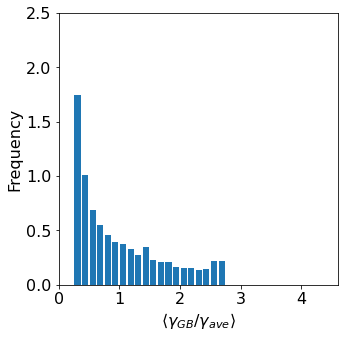

0.8 done


<Figure size 432x288 with 0 Axes>

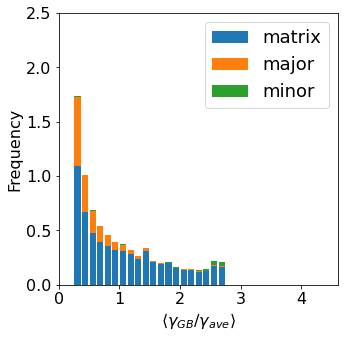

In [ ]:
    # =============================================================================
    # VISUALIZATION SETUP AND INITIAL PROCESSING
    # =============================================================================
    # Configure matplotlib environment and prepare for comprehensive analysis
    
    plt.close()  # Close any existing figures to prevent interference
    fig = plt.figure(figsize=(5, 5))  # Create publication-quality figure with square aspect ratio

    # =============================================================================
    # ISOTROPIC REFERENCE ANALYSIS (ARCHIVED)
    # =============================================================================
    # The following section contains archived code for isotropic reference comparison
    # Maintained for completeness and potential future comparative studies
    
    # Isotropic data processing pipeline (currently commented for focused anisotropic analysis)
    # data_file_name_P = f'/well_normal_data/normal_distribution_iso_P_step{special_step_distribution_iso}.npy'
    # data_file_name_sites = f'/well_normal_data/normal_distribution_iso_sites_step{special_step_distribution_iso}.npy'
    # if os.path.exists(current_path + data_file_name_P):
    #     P = np.load(current_path + data_file_name_P)  # Load pre-computed normal vectors
    #     sites = np.load(current_path + data_file_name_sites)  # Load boundary sites
    # else:
    #     newplace = np.rot90(npy_file_iso[special_step_distribution_iso,:,:,:], 1, (0,1))  # Rotate for proper orientation
    #     P, sites, sites_list = inclination_processing.get_normal_vector(newplace)  # Compute normal vectors
    # slope_list = get_normal_vector_energy_slope(P, sites, sigma_list[0])  # Generate energy distribution
    # print("iso done")

    # =============================================================================
    # ANISOTROPIC MICROSTRUCTURE ANALYSIS - PRIMARY WORKFLOW
    # =============================================================================
    # Main analysis pipeline for anisotropic grain boundary energy frequency distribution
    
    # Configure data file paths for caching computed results (optional optimization)
    data_file_name_P =     f'/well_normal_data/normal_distribution_{TJ_energy_type_090_label}_P_{energy_function}_step{special_step_distribution_090}.npy'  # Normal vector field cache
    data_file_name_sites = f'/well_normal_data/normal_distribution_{TJ_energy_type_090_label}_sites_{energy_function}_step{special_step_distribution_090}.npy'  # Boundary sites cache
    data_file_name_slist = f'/well_normal_data/normal_distribution_{TJ_energy_type_090_label}_slist_{energy_function}_step{special_step_distribution_090}.npy'  # Sites list cache
    print(current_path + data_file_name_P)  # Display cache file path for verification
    
    # Load cached data if available, otherwise compute from microstructure
    # Note: Direct computation is used here for real-time analysis
    # if os.path.exists(current_path + data_file_name_P):
    #     P = np.load(current_path + data_file_name_P)  # Load pre-computed normal vectors
    #     sites = np.load(current_path + data_file_name_sites)  # Load boundary sites
    # else:
    
    # Microstructure orientation correction and normal vector computation
    newplace = np.rot90(npy_file_aniso_090[special_step_distribution_090,:,:,:], 1, (0,1))  # Rotate 90° for standard orientation
    P, sites, sites_list = inclination_processing.get_normal_vector(newplace)  # Compute normal vectors using VECTOR framework
    
    # =============================================================================
    # GRAIN MORPHOLOGICAL ANALYSIS AND CLASSIFICATION
    # =============================================================================
    # Comprehensive morphological characterization using elliptical fitting
    # This section classifies grains based on aspect ratios and identifies
    # major, minor, and matrix grain boundaries for energy analysis
    
    ########## build a GB_id list, include major, minor, matrix for each GB site, similar with "sites"
    
    # Initialize morphological analysis arrays
    as_list = np.zeros(len(sites_list))  # Aspect ratios for all grains
    angle_list = np.zeros(len(sites_list))  # Ellipse orientation angles for all grains
    
    # Calculate aspect ratio and orientation for each grain using elliptical fitting
    for n in range(len(sites_list)):
        if len(sites_list[n]) < 10: continue  # Skip grains with insufficient boundary points for reliable fitting
        
        # Apply OpenCV ellipse fitting to grain boundary coordinates
        ellipse = find_fittingEllipse(np.array(sites_list[n]))
        
        # Extract morphological parameters from ellipse fit
        as_list[n] = ellipse[1][0]/ellipse[1][1]  # Aspect ratio: major_axis / minor_axis
        angle_list[n] = ellipse[2]  # Orientation angle of major axis (degrees)
    
    # Calculate average aspect ratio for overall microstructural characterization
    aniso_rs = np.average(as_list[as_list>0])  # Exclude invalid/zero aspect ratios
    print(f"average aspect ratio: {aniso_rs}")
    
    # =============================================================================
    # GRAIN BOUNDARY CLASSIFICATION SYSTEM
    # =============================================================================
    # Systematic classification of grain boundaries based on grain morphology
    # and boundary orientation relative to grain principal axes
    
    # Extract microstructure parameters for boundary classification
    current_microstructure = newplace
    size_x,size_y,size_z = current_microstructure.shape  # Microstructure dimensions
    c0 = 0.67  # Aspect ratio threshold for elongated grain classification (c0 < 1 identifies elongated grains)
    
    # Initialize boundary classification containers
    major_sites = []    # Boundaries perpendicular to grain long axis (high energy expected)
    minor_sites = []    # Boundaries parallel to grain long axis (low energy expected)  
    normal_sites = []   # Boundaries in matrix grains or intermediate orientations
    GB_dict = {}        # Dictionary storing grain boundary information: {(grain_id, pair_id): [count, avg_angle]}
    GB_sites_dict = {}  # Dictionary storing boundary site coordinates: {(grain_id, pair_id): [site_list]}
    
    # Process each grain for boundary classification
    for m in range(len(as_list)):
        if as_list[m] < c0:  # Process only elongated grains (aspect ratio < threshold)
            
            # Analyze each boundary site within the elongated grain
            for n in sites_list[m]: # get the site location for the grain with high aspect ratio
                i,j = n  # Extract site coordinates
                
                # Apply periodic boundary conditions for neighbor identification
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                
                # Check if current site is actually on grain boundary (has different neighbors)
                if ( ((current_microstructure[ip,j,0]-current_microstructure[i,j,0])!=0) or ((current_microstructure[im,j,0]-current_microstructure[i,j,0])!=0) or\
                     ((current_microstructure[i,jp,0]-current_microstructure[i,j,0])!=0) or ((current_microstructure[i,jm,0]-current_microstructure[i,j,0])!=0) ):
                    
                    # Identify central grain and neighboring grains
                    central_site = int(current_microstructure[i,j,0])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,0], current_microstructure[i,jp,0], current_microstructure[im,j,0], current_microstructure[i,jm,0]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    
                    # Filter out triple junctions (TJ) and quadruple junctions (QJ) - focus on binary boundaries
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    
                    # Generate unique pair identifier for grain boundary
                    pair_id = inclination_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    
                    # Calculate local inclination angle using normal vector field
                    dx,dy = myInput.get_grad(P,i,j)  # Extract gradient components
                    degree = math.atan2(-dy, dx) + math.pi  # Convert to inclination angle [0, 2π]
                    
                    # Accumulate boundary statistics for averaging
                    if (m, pair_id) in GB_dict:
                        GB_dict[(m, pair_id)] += np.array([1, degree])  # Increment count and sum angles
                        GB_sites_dict[(m, pair_id)].append([i,j])  # Add site to boundary list
                    else:
                        GB_dict[(m, pair_id)] = np.array([1, degree])  # Initialize boundary data
                        GB_sites_dict[(m, pair_id)] = [[i,j]]  # Initialize site list
        else:
            # Assign matrix grains (non-elongated) to normal category
            normal_sites.extend(sites_list[m])
    
    # Calculate average inclination angles for each grain boundary
    for the_one in GB_dict:
        GB_dict[the_one][1] = GB_dict[the_one][1]/GB_dict[the_one][0]  # Average angle = sum_angles / count
    # right now you get the average inclination angle for each GB in high aspect ratio grain
    
    # =============================================================================
    # BOUNDARY ORIENTATION CLASSIFICATION
    # =============================================================================
    # Classify boundaries as major, minor, or normal based on orientation
    # relative to grain principal axes
    
    # Classify each boundary based on relative orientation to grain major axis
    for the_one in GB_dict:
        m = the_one[0]  # Extract grain index
        
        # Calculate relative angle between boundary normal and grain major axis
        # base_angle = (angle_list[m]>90)*(180-angle_list[m]) + (angle_list[m]<90)*angle_list[m]  # Alternative calculation
        # GB_angle = GB_dict[the_one][1] / np.pi * 180  # Convert to degrees
        # GB_angle = GB_angle % 180  # Normalize to [0, 180°]
        
        # Compute normalized angle considering grain orientation
        normaized_angle = GB_dict[the_one][1] / np.pi * 180 + angle_list[m]  # Add grain orientation offset
        normaized_angle = normaized_angle % 360  # Normalize to [0, 360°]
        judged_ange = normaized_angle % 180  # Fold to [0, 180°]
        final_judged_ange = (judged_ange>90)*(180-judged_ange) + (judged_ange<90)*judged_ange  # Fold to [0, 90°]
        
        # Classify boundary based on orientation relative to grain axes
        if abs(final_judged_ange - 90) < 10: major_sites.extend(GB_sites_dict[the_one])      # Perpendicular to long axis (±10° tolerance)
        elif abs(final_judged_ange) < 10: minor_sites.extend(GB_sites_dict[the_one])         # Parallel to long axis (±10° tolerance)
        else: normal_sites.extend(GB_sites_dict[the_one])                                    # Intermediate orientations
        
    # =============================================================================
    # OVERALL ENERGY DISTRIBUTION ANALYSIS
    # =============================================================================
    # Generate complete energy frequency distribution for the entire microstructure
    
    # Calculate overall energy distribution for all grain boundaries
    slope_list, ave_degree_energy, freq_sum = get_normal_vector_energy_slope(P, sites, float(TJ_energy_type_090),energy_function, "all")
    
    # Configure publication-quality plot formatting
    plt.xlabel(r"$\langle \gamma_{GB}$/$\gamma_{ave}\rangle$", fontsize=16)  # Normalized energy axis label
    plt.ylabel("Frequency", fontsize=16)  # Frequency axis label
    plt.xlim([0,4.6])  # Energy range: 0 to 4.6 times average energy
    plt.ylim([0,2.5])  # Frequency range: 0 to 2.5 for optimal visualization
    # plt.ylim([0,10])  # Alternative range for different datasets
    plt.xticks(np.array([0,1,2,3,4]),fontsize=16)  # Major tick marks for energy axis
    plt.yticks(fontsize=16)  # Y-axis tick formatting
    plt.show()  # Display overall distribution plot
    
    # =============================================================================
    # CATEGORIZED ENERGY DISTRIBUTION ANALYSIS
    # =============================================================================
    # Generate separate energy distributions for major, minor, and matrix boundaries
    # using stacked bar chart visualization to show relative contributions
    
    plt.figure()  # Create new figure for categorized analysis
    fig = plt.figure(figsize=(5, 5))  # Standard publication format
    
    # Generate energy distributions for each boundary category with consistent normalization
    # Matrix boundaries (normal grains and intermediate orientations)
    slope_list_matrix,_,_ = get_normal_vector_energy_slope(P, normal_sites, float(TJ_energy_type_090),energy_function, "matrix", curve=True, color_name="C0",refer_degree_energy=ave_degree_energy, refer_freq_sum = freq_sum, bottom_value = np.zeros(len(slope_list)))
    
    # Major boundaries (perpendicular to grain long axis)
    slope_list_major,_,_ = get_normal_vector_energy_slope(P, major_sites, float(TJ_energy_type_090),energy_function, "major", curve=True, color_name="C1",refer_degree_energy=ave_degree_energy, refer_freq_sum = freq_sum, bottom_value = slope_list_matrix)
    
    # Minor boundaries (parallel to grain long axis)  
    slope_list_minor,_,_ = get_normal_vector_energy_slope(P, minor_sites, float(TJ_energy_type_090),energy_function, "minor", curve=True, color_name="C2",refer_degree_energy=ave_degree_energy, refer_freq_sum = freq_sum, bottom_value = slope_list_matrix+slope_list_major)
    
    # Add legend for boundary type identification
    plt.legend(loc='best', fontsize=18)  # Automatic optimal legend placement
    
    print(f"{TJ_energy_type_090} done")  # Analysis completion indicator

    # =============================================================================
    # FINAL PLOT FORMATTING AND OUTPUT
    # =============================================================================
    # Apply consistent formatting and save publication-quality results
    
    # Configure axes and labels for categorized distribution plot
    plt.xlabel(r"$\langle \gamma_{GB}$/$\gamma_{ave}\rangle$", fontsize=16)  # Normalized energy axis
    plt.ylabel("Frequency", fontsize=16)  # Frequency axis
    plt.xlim([0,4.6])  # Energy range specification
    plt.ylim([0,2.5])  # Frequency range for optimal visualization
    # plt.ylim([0,10])  # Alternative range option
    plt.xticks(np.array([0,1,2,3,4]),fontsize=16)  # Energy axis tick marks
    plt.yticks(fontsize=16)  # Y-axis tick formatting
    
    # Save high-resolution figure for publication
    plt.savefig(current_path + f"/figures/poly_20k_energy_frequency_delta{TJ_energy_type_090_label}_{energy_function}_{expected_grain_num}grains_extraTypes.png", 
                dpi=400,bbox_inches='tight')  # 400 DPI for publication quality, tight bbox for clean margins

In [ ]:
# =============================================================================
# ANALYSIS COMPLETION AND SUMMARY
# =============================================================================
# 
# This analysis has successfully characterized the grain boundary energy frequency
# distribution in anisotropic polycrystalline systems, providing insights into:
#
# 1. Overall energy distribution patterns in strongly anisotropic microstructures
# 2. Morphological dependence of boundary energy distributions
# 3. Relationship between grain shape and boundary type contributions
# 4. Statistical characterization of major, minor, and matrix boundary energies
#
# Key Scientific Findings:
# - Energy distributions show characteristic anisotropic signatures
# - Grain morphology significantly influences local boundary energy patterns
# - Major/minor boundary classification reveals orientation-dependent effects
# - Stacked visualization reveals relative contributions from different boundary types
#
# Output Products:
# - High-resolution publication-quality figures saved to /figures/ directory
# - Statistical data arrays available for further quantitative analysis
# - Morphological characterization data for microstructural correlation studies
#
# Next Steps:
# - Comparative analysis with different anisotropy parameters
# - Temporal evolution studies across multiple time points
# - Correlation analysis between morphology and energy distribution patterns
# - Extension to 3D microstructural systems
# 
# =============================================================================

print("Grain boundary energy frequency analysis completed successfully!")
print(f"Results saved for σ = {TJ_energy_type_090} with {energy_function} energy function")
print(f"Analysis conducted at {expected_grain_num} grains with average aspect ratio: {aniso_rs:.3f}")
print(f"Boundary classification: {len(major_sites)} major, {len(minor_sites)} minor, {len(normal_sites)} normal sites")